# Comorbidity analysis

In [1]:
import difflib
import re
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pylab import *
import seaborn as sns

%matplotlib inline

## Conditions database

In [87]:
ds = pd.read_csv('../output/conditions/data.csv', low_memory=False)
ds_drop = ds.drop('entity_id', 1).dropna()
ds_drop.rename(columns=lambda x: x.replace('ENFERMEDADES_', ''), inplace=True)

## Calculate comorbidity frequency

In [88]:
ds_asint = ds_drop.astype(int)
coocurrences = ds_asint.T.dot(ds_asint).as_matrix()
coocurrences

array([[ 275,   10,   49, ...,    1,    7,    2],
       [  10,  434,  189, ...,   15,  262,   95],
       [  49,  189, 1895, ...,    5,  140,   12],
       ..., 
       [   1,   15,    5, ...,   15,    0,    0],
       [   7,  262,  140, ...,    0,  262,    0],
       [   2,   95,   12, ...,    0,    0,   95]])

## Relative Risk

The Relative Risk (RR) of observing a pair of diseases $i$ and $j$ affecting the same patient is given by

$$RR_ij = \frac{C_ijN}{P_iP_j}$$ where $C_ij$ is the number of patients affected by both diseases, $N$ is the total number of patients in the population and $P_i$ and $P_j$ are the prevalences of diseases $i$ and $j$.

In [89]:
from __future__ import division

def RR(c, N, i, j):
    if (c[i,i]*c[j,j] == 0):
        return(0)
    if (i == j):
        return 0
    return (c[i,j]*N)/(c[i,i]*c[j,j])

In [111]:
N = ds_asint.shape[0]
risk = coocurrences.copy().astype(float)

for i in range(0, coocurrences.shape[0], 1):
    for j in range(0, coocurrences.shape[1], 1):
        risk[i,j] = RR(coocurrences, N, i, j)
        
risk = pd.DataFrame(risk, index=ds_drop.columns, columns=ds_drop.columns)
risk.to_csv('../output/relative-risk/data.csv')

## Filter RR

In [113]:
def filterRR(df, RR):
    risk_df = pd.DataFrame(df)
    risk_df['condition'] = risk_df.index
    risk_df = pd.melt(risk_df, id_vars=['condition'])
    risk_df = risk_df[risk_df['value'] > RR].sort_values(by=['value'], ascending=[0])
    risk_df_pivot = risk_df.pivot(index='condition', columns='variable')['value']
    risk_df_pivot = risk_df_pivot.fillna(0)
    return risk_df_pivot

## Plot disease relative risk matrix

<module 'matplotlib.pyplot' from '/software/debian-8/general/virtenvs/jupyter/lib/python3.5/site-packages/matplotlib/pyplot.py'>

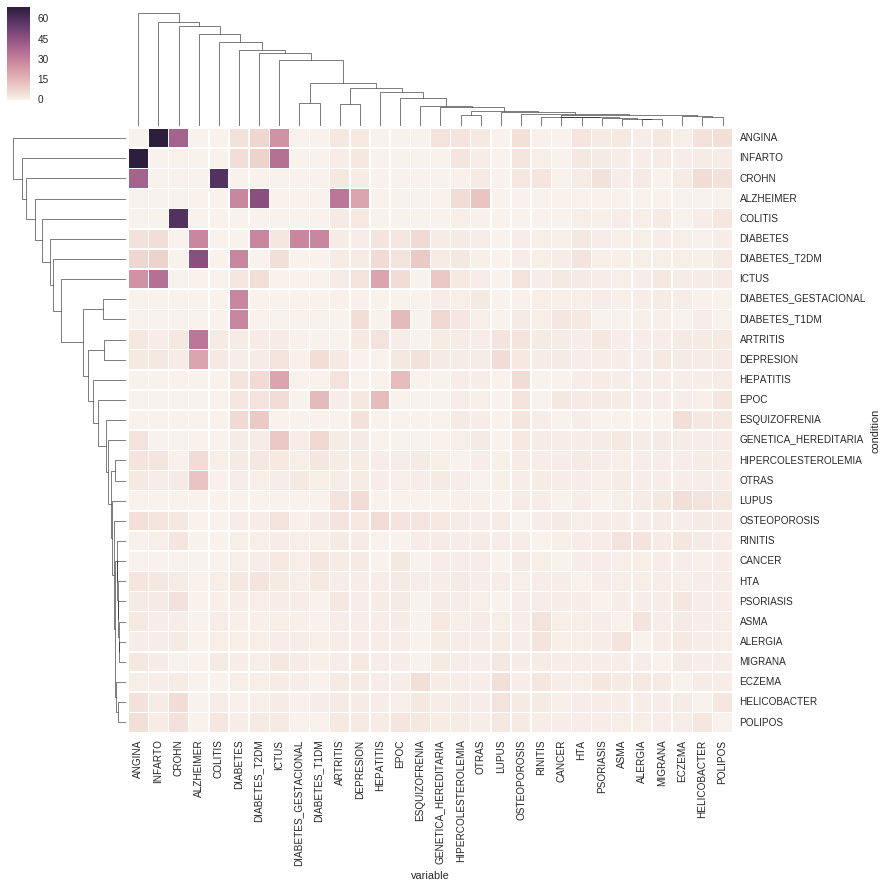

In [120]:
df = filterRR(risk, 0)
cg = sns.clustermap(df, linewidths=.5, figsize=(13, 13))
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt